## Environment Setting and Data Loading

In [1]:
import pandas as pd
import numpy as np

In [2]:
from gensim.models import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models import TfidfModel
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import spacy
import gensim
import time

In [3]:
import multiprocessing

num_processors = multiprocessing.cpu_count()
num_processors

20

In [4]:
# !pip install pandarallel

In [4]:
from pandarallel import pandarallel

# Initialize pandarallel
pandarallel.initialize(nb_workers = multiprocessing.cpu_count()-1, use_memory_fs=False, progress_bar=True)

INFO: Pandarallel will run on 19 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [6]:
start_time = time.time()

def tic():
    global start_time 
    start_time = time.time()

def tac():
    t_sec = round(time.time() - start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print(f'Execution time to calculate for topic {k}: {t_hour}hour:{t_min}min:{t_sec}sec'.format(t_hour,t_min,t_sec))

In [8]:
%%time
import pickle
df_filtered = pd.read_pickle('filtered_data_sentiment_NER.pkl')
df_filtered.head(1)

CPU times: total: 6.33 s
Wall time: 18 s


,date,domain,clean_title,clean_text,clean_token,sentiment_score_vader,sentiment_vader,sentiment_svm,sentiment_score_vader_customized,sentiment_vader_customized,NER_word,ORG_NER,PERSON_NER,GPE_NER,sentiment_ner
0,2021-03-18,en.people.cn,Artificial intelligence improves parking effic...,Thanks to the application of an artificial int...,thanks application artificial intelligence ai ...,0.997,Positive,0,0.9961,Positive,"[[ETC, ETC, AI, Wang, ETC, Wang, ETC, Ministry...","[ETC, ETC, AI, Wang, ETC, Wang, ETC, Ministry ...","[Xiang Yanping, Xiang]","[China, Beijing, Chaoyang, Beijing, Beijing, B...",E...


In [9]:
df_filtered.shape

(165530, 15)

## LDA with Hyperparameter Tuning with Sample

In [9]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

In [10]:
df_sample = df_filtered.sample(frac=0.05, random_state=1)
df_sample.shape

(8276, 15)

In [12]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations


        
sample_list = df_sample['clean_text'].tolist()        
sample_tokens = list(sent_to_words(sample_list))

In [13]:
bigram = gensim.models.Phrases(sample_tokens, min_count=1, threshold=1)
trigram = gensim.models.Phrases(bigram[sample_tokens], threshold=1)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [14]:
stop_words = stopwords.words('english')

# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [15]:
# Remove Stop Words
sample_tokens_nostops = remove_stopwords(sample_tokens)

# Create n-grams
sample_words_trigrams = make_trigrams(sample_tokens_nostops)

# Combine tokens and n-grams (this time we only do trigrams)
sample_tokens_combined = sample_words_trigrams 

# Lemmatize text keeping only noun, adj, vb, adv
sample_lemmatized = lemmatization(sample_tokens_combined, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [16]:
# Creating the term dictionary of our courpus, where every unique term is assigned an index. 
sample_dictionary = corpora.Dictionary(sample_lemmatized)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
sample_doc_term_matrix = [sample_dictionary.doc2bow(doc) for doc in sample_lemmatized]

In [17]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b, data_lemmatized):
    
    lda_model = LdaMulticore(corpus=corpus,
                       id2word=dictionary,
                       num_topics=k,
                       random_state=100,                  
                       passes=10,
                       alpha=a,
                       eta=b,
                       workers=num_processors-1)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [18]:
grid = {}
grid['Validation_Set'] = {}
# Topics range
topics_range = [20, 25, 30, 140, 150]

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')
# alpha = ['asymmetric'] # Run for number of topics only

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')
# beta = ['auto'] # Run for number of topics only


# Validation sets
num_of_docs = len(sample_doc_term_matrix)
corpus_sets = [# gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.5), 
               # gensim.utils.ClippedCorpus(doc_term_matrix, num_of_docs*0.75), 
               sample_doc_term_matrix] # simply use the whole matrix

# corpus_title = ['75% Corpus', '100% Corpus']
corpus_title = ['100% Corpus']
model_results = {
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

itr = 0
itr_total = len(beta)*len(alpha)*len(topics_range)*len(corpus_title)
print(f'LDA will execute {itr_total} iterations')

    
# iterate through hyperparameters
for i in range(len(corpus_sets)):
    # iterate through number of topics
    for k in topics_range:
        # iterate through alpha values
        tic()
        for a in alpha:
            # iterare through beta values
            for b in beta:
                # get the coherence score for the given parameters
                itr += 1
                cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=sample_dictionary, 
                                              k=k, a=a, b=b, data_lemmatized=sample_lemmatized)
                # Save the model results
                model_results['Topics'].append(k)
                model_results['Alpha'].append(a)
                model_results['Beta'].append(b)
                model_results['Coherence'].append(cv)
                pct_completed = round((itr / itr_total * 100),1)
                # print(f'Completed Percent: {pct_completed}%, Corpus: {corpus_title[i]}, Topics: {k}, Alpha: {a}, Beta: {b}, Coherence: {cv}')
        print(f'Completed model based on {k} LDA topics. Finished {pct_completed}% of LDA runs')
        tac()
                    
sample_lda_tuning = pd.DataFrame(model_results)
sample_lda_tuning

LDA will execute 150 iterations
Completed model based on 20 LDA topics. Finished 20.0% of LDA runs
Execution time to calculate for topic 20: 0hour:57min:32sec
Completed model based on 25 LDA topics. Finished 40.0% of LDA runs
Execution time to calculate for topic 25: 1hour:13min:36sec
Completed model based on 30 LDA topics. Finished 60.0% of LDA runs
Execution time to calculate for topic 30: 1hour:26min:17sec
Completed model based on 140 LDA topics. Finished 80.0% of LDA runs
Execution time to calculate for topic 140: 3hour:28min:3sec
Completed model based on 150 LDA topics. Finished 100.0% of LDA runs
Execution time to calculate for topic 150: 4hour:44min:23sec


,Topics,Alpha,Beta,Coherence
0,20,0.01,0.01,0.362910
1,20,0.01,0.31,0.410539
2,20,0.01,0.61,0.484452
3,20,0.01,0.91,0.469680
4,20,0.01,symmetric,0.354605
...,...,...,...,...
145,150,asymmetric,0.01,0.368227
146,150,asymmetric,0.31,0.466991
147,150,asymmetric,0.61,0.466836
148,150,asymmetric,0.91,0.447392


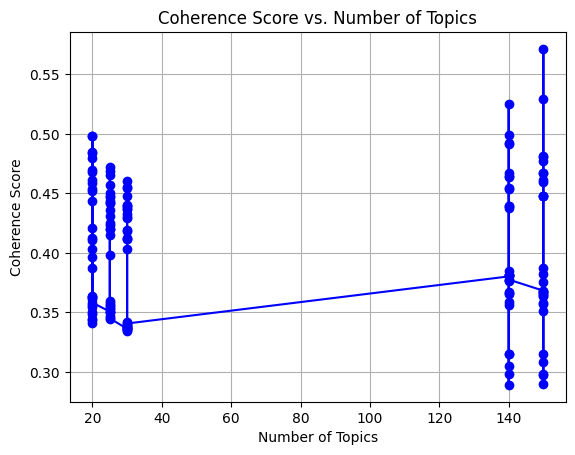

In [19]:
# Plot coherence scores
plt.plot(sample_lda_tuning['Topics'].to_numpy(), sample_lda_tuning['Coherence'].to_numpy(), 'b-o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Score vs. Number of Topics')
plt.grid(True)
plt.show()

In [20]:
max_row_index = sample_lda_tuning['Coherence'].idxmax()
max_row = sample_lda_tuning.loc[max_row_index]
max_row

Topics            150
Alpha            0.31
Beta             0.91
Coherence    0.571352
Name: 128, dtype: object

In [20]:
best_sample_lda_model = LdaMulticore(corpus=sample_doc_term_matrix,
                   id2word=sample_dictionary,
                   num_topics=150,
                   random_state=100,                  
                   passes=10,
                   alpha=0.31,
                   eta=0.91,
                   workers=num_processors-1)


In [21]:

topics = best_sample_lda_model.print_topics(num_topics=150, num_words=10)
topic_data = []

for topic in topics:
    words = topic[1].split("+")
    topic_words = [word.split("*")[1].strip().replace('"', '') for word in words]
    topic_data.append(topic_words)

df_topics = pd.DataFrame(topic_data, columns=[f"Topic{i}" for i in range(10)])
df_topics.insert(0, "Topic", range(150))


In [44]:
df_topics

,Topic,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9
0,0,ҳлиө,wind,ләел_мқј,ҳл_ҙм,җлҹ,ҳлқҳ,ҳкің,лҙј,ліҙлҙј,нҷ
1,1,arena_analytic,training_sample,distinguished_industry,use,smother,market,zac,deep_convolutional_neural_network,naturally_stop,connect_women
2,2,medical_ai_data_analysis,first_picture,google_parent_company_alphabet,steamtown,performances_take,wednesday_alphabet,widespread_job_cut,knowing_machine,tech_sector_alphabet_cut,engine_publicly
3,3,pmsport,match_feb,wickets_root,ing_car,market,use,ai,company,say,technology
4,4,transaction_review,uses_advance,use,billing_detail,bonifazidenver_co,cofive,ai,datum,say,technology_digit
...,...,...,...,...,...,...,...,...,...,...,...
145,145,wvlt_newsfirst,wayanythe,teamcareerswvlt_paid,alert_weatherfirst_alert_weather,alert_live,dividesupport_local,calendarcontact_usmeet,solutionsmedal,cookingeye,possiblelet_get
146,146,technology_review,alphafold,fox_business,protein,rogd,proteins_found,refinitiv_lipper,million_structure,statement_mutual,market_data_provide
147,147,market,report,santo_cjmorne,invest,call_trading_calls_trade,markets_data_exclusive_trade,thomson_reutersdetail,equity_analysis_actionable_investment,sip_balancerdelay,trackersip_performance
148,148,new_exhibition,world_renowned,rapture,press_preview,content_markete,market,lisbon,complainour_brandsprivacy,bicycle,franca


In [ ]:
visible_best_sample_lda_model = LdaMulticore(corpus=sample_doc_term_matrix,
                   id2word=sample_dictionary,
                   num_topics=20,
                   random_state=100,                  
                   passes=10,
                   alpha=0.31,
                   eta=0.61,
                   workers=num_processors-1)

In [ ]:
topics = visible_best_sample_lda_model.print_topics(num_topics=20, num_words=10)
topic_data = []

for topic in topics:
    words = topic[1].split("+")
    topic_words = [word.split("*")[1].strip().replace('"', '') for word in words]
    topic_data.append(topic_words)

df_topics = pd.DataFrame(topic_data, columns=[f"Topic{i}" for i in range(10)])
df_topics.insert(0, "Topic", range(20))

In [ ]:
df_topics.head(20)

## Ktrain with Found Optimal n_topics

#### Setting

In [4]:
import tensorflow as tf

In [5]:
#Verify we got CPU + GPU or only CPU
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [24]:
#!pip install ktrain

In [6]:
import ktrain
from ktrain import text as txt

print('Ktrain Version: ' + ktrain.__version__)

Ktrain Version: 0.37.0


In [10]:
texts = df_filtered['clean_token'].tolist()

#### 5 topics

In [27]:
tm_5 = ktrain.text.get_topic_model(
    texts=texts, 
    n_topics=5, 
    n_features=10000, 
    min_df=5, 
    max_df=0.5, 
    stop_words='english', 
    model_type='lda', 
    lda_max_iter=5, 
    verbose=1)

lang: en
preprocessing texts...
fitting model...
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
done.


In [28]:
tm_5.print_topics()

topic 0 | share stock news investment fund dollar best investor trade price
topic 1 | solution customer learning business platform service machine help model use
topic 2 | chatgpt said like google human use people tool user time
topic 3 | market report global artificial analysis growth industry research forecast key
topic 4 | republic said news state say people day year india world


#### 20 topics

In [11]:
tm_20 = ktrain.text.get_topic_model(
    texts=texts, 
    n_topics=20, 
    n_features=10000, 
    min_df=5, 
    max_df=0.5, 
    stop_words='english', 
    model_type='lda', 
    lda_max_iter=5, 
    verbose=1)

lang: en
preprocessing texts...
fitting model...
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
done.


In [12]:
tm_20.print_topics()

topic 0 | stock share dollar fund traded trade price nasdaq btc investment
topic 1 | year million billion startup venture according time firm investor space
topic 2 | like people say human thing make work time think way
topic 3 | patient health medical healthcare care drug cancer disease clinical hospital
topic 4 | science education world artificial research industry global business student development
topic 5 | image video art like voice create content artist music tool
topic 6 | best insurance credit crypto real finance card forbes paid estate
topic 7 | security said use law risk privacy government artificial legal policy
topic 8 | learning machine device chip edge computing nvidia catheter deep processing
topic 9 | model learning researcher algorithm human research used machine using science
topic 10 | vehicle robot smart vision car energy camera computer sensor autonomous
topic 11 | solution platform customer business cloud service enterprise software application product
topic 12 |

#### Label Useful Results and Save to Local

In [13]:
import pandas as pd
df_topic = pd.read_pickle('filtered_data_topic.pkl')

In [15]:
df_topic.head(1)

,date,domain,clean_title,clean_text,clean_token,sentiment_score_vader,sentiment_vader,sentiment_svm,sentiment_score_vader_customized,sentiment_vader_customized,NER_word,ORG_NER,PERSON_NER,GPE_NER,sentiment_ner,clean_text_without_stopwords,bert_auto_topic_id
0,2021-03-18,en.people.cn,Artificial intelligence improves parking effic...,Thanks to the application of an artificial int...,thanks application artificial intelligence ai ...,0.997,Positive,0,0.9961,Positive,"[[ETC, ETC, AI, Wang, ETC, Wang, ETC, Ministry...","[ETC, ETC, AI, Wang, ETC, Wang, ETC, Ministry ...","[Xiang Yanping, Xiang]","[China, Beijing, Chaoyang, Beijing, Beijing, B...",E...,Thanks application artificial intelligence ( A...,9


In [16]:
import numpy as np

topic_probabilities = tm_20.predict(texts)
topic_ids = np.argmax(topic_probabilities, axis=1)
df_topic['ktrain_20_topic_id'] = topic_ids


In [17]:
df_topic.head(1)

,date,domain,clean_title,clean_text,clean_token,sentiment_score_vader,sentiment_vader,sentiment_svm,sentiment_score_vader_customized,sentiment_vader_customized,NER_word,ORG_NER,PERSON_NER,GPE_NER,sentiment_ner,clean_text_without_stopwords,bert_auto_topic_id,ktrain_20_topic_id
0,2021-03-18,en.people.cn,Artificial intelligence improves parking effic...,Thanks to the application of an artificial int...,thanks application artificial intelligence ai ...,0.997,Positive,0,0.9961,Positive,"[[ETC, ETC, AI, Wang, ETC, Wang, ETC, Ministry...","[ETC, ETC, AI, Wang, ETC, Wang, ETC, Ministry ...","[Xiang Yanping, Xiang]","[China, Beijing, Chaoyang, Beijing, Beijing, B...",E...,Thanks application artificial intelligence ( A...,9,10


In [18]:
# finance
df_topic[df_topic.ktrain_20_topic_id == 0].shape

(6345, 18)

In [19]:
# healthcare
df_topic[df_topic.ktrain_20_topic_id == 3].shape

(7776, 18)

In [20]:
# education
df_topic[df_topic.ktrain_20_topic_id == 4].shape

(10111, 18)

In [21]:
# art/music/design
df_topic[df_topic.ktrain_20_topic_id == 5].shape

(7094, 18)

In [22]:
# automotive
df_topic[df_topic.ktrain_20_topic_id == 10].shape

(3685, 18)

In [23]:
# entertainment
df_topic[df_topic.ktrain_20_topic_id == 14].shape

(2312, 18)

In [24]:
# companies and technologies
df_topic[df_topic.ktrain_20_topic_id == 19].shape

(11587, 18)

In [37]:
# mapping
topic_mapping = {6: "finance", 
                 3: "healthcare", 
                 4: "education", 
                 5: "studio_art", 
                 10: "automotive", 
                 14: "entertainment", 
                 19: "company_technology"}


df_topic['ktrain_topic'] = df_topic['ktrain_20_topic_id'].map(topic_mapping).fillna("Others")

In [38]:
df_topic.ktrain_topic.value_counts()

Others                121378
company_technology     11587
education              10111
healthcare              7776
studio_art              7094
automotive              3685
entertainment           2312
finance                 1587
Name: ktrain_topic, dtype: int64

In [39]:
df_topic.head(1)

,date,domain,clean_title,clean_text,clean_token,sentiment_score_vader,sentiment_vader,sentiment_svm,sentiment_score_vader_customized,sentiment_vader_customized,NER_word,ORG_NER,PERSON_NER,GPE_NER,sentiment_ner,clean_text_without_stopwords,bert_auto_topic_id,ktrain_20_topic_id,ktrain_topic
0,2021-03-18,en.people.cn,Artificial intelligence improves parking effic...,Thanks to the application of an artificial int...,thanks application artificial intelligence ai ...,0.997,Positive,0,0.9961,Positive,"[[ETC, ETC, AI, Wang, ETC, Wang, ETC, Ministry...","[ETC, ETC, AI, Wang, ETC, Wang, ETC, Ministry ...","[Xiang Yanping, Xiang]","[China, Beijing, Chaoyang, Beijing, Beijing, B...",E...,Thanks application artificial intelligence ( A...,9,10,automotive


In [40]:
df_topic.to_pickle("filtered_data_topic.pkl")

#### 150 topics

In [31]:
tm_150 = ktrain.text.get_topic_model(
    texts=texts, 
    n_topics=150, 
    n_features=10000, 
    min_df=5, 
    max_df=0.5, 
    stop_words='english', 
    model_type='lda', 
    lda_max_iter=5, 
    verbose=1)

lang: en
preprocessing texts...
fitting model...
iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5
iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5
done.


In [32]:
tm_150.print_topics()

topic 0 | oil gas price market say stock min inflation rate bank
topic 1 | patient health healthcare medical care hospital clinical imaging disease treatment
topic 2 | google said tech year giant alphabet according week pichai ceo
topic 3 | center contact agent var customer node research request communication field
topic 4 | research project engineering community team said work join access building
topic 5 | updated hour minute prnewsfoto skip news today announced logo weather
topic 6 | cancer breast lunit study screening tissue patient lung clinical image
topic 7 | light eye noise radio station motion zoom mode cool room
topic 8 | camera sensor design module application power product embedded control kit
topic 9 | scott daniel club allen hill suicide thomas colorado delta brown
topic 10 | city traffic transportation road urban location transport map forest download
topic 11 | canada canadian toronto ontario assange donor say montreal urine bell
topic 12 | artificial market report anal

## BERTopic

#### Setting

In [ ]:
# !pip install bertopic

In [1]:
from bertopic import BERTopic
# from sentence_transformers import SentenceTransformer

e:\miniconda3\envs\general\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
e:\miniconda3\envs\general\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
e:\miniconda3\envs\general\lib\site-packages\umap\distances.py:1086: NumbaDeprecationWarning: The 'nopython'

RuntimeError: Failed to import transformers.pipelines because of the following error (look up to see its traceback):
[WinError 182] 操作系统无法运行 %1。 Error loading "e:\miniconda3\envs\general\lib\site-packages\torch\lib\shm.dll" or one of its dependencies.

In [34]:
def remove_stopwords(sentence):
    from nltk.tokenize import word_tokenize
    from nltk.corpus import stopwords
    stop_words = stopwords.words('english')
    tokens = word_tokenize(sentence)
    filtered_sentence = [word for word in tokens if not word in stop_words]
    return " ".join(filtered_sentence)

In [35]:
%%time
df_filtered['clean_text_without_stopwords'] = df_filtered['clean_text'].parallel_apply(remove_stopwords)

CPU times: total: 3.58 s
Wall time: 1min 20s


#### On Sample

In [ ]:
# first try on sample
df_sample = df_filtered.sample(n=10000)
sample_documents = df_sample['clean_text_without_stopwords'].tolist()  

In [ ]:
# Create a BERTopic model
sample_topic_model_auto = BERTopic(embedding_model="bert-base-nli-mean-tokens",  min_topic_size=50)

In [ ]:
sample_topics, sample_probabilities = sample_topic_model_auto.fit_transform(sample_documents)

In [ ]:
sample_topic_keywords = sample_topic_model_auto.get_topic_info()

In [ ]:
for topic in sample_topic_keywords['Topic'].unique():
    sample_keywords = sample_topic_model_auto.get_topic(topic)
    sample_keywords, _ = zip(*sample_keywords[:5])  # unzip keywords and probabilities, ignore probabilities
    print(f"Topic {topic} Keywords: {sample_keywords}")

#### On Full Dataset

##### Auto n_topics

In [36]:
# Create a BERTopic model
topic_model_auto = BERTopic(embedding_model="bert-base-nli-mean-tokens",  min_topic_size=100)

In [37]:
%%time
topics_auto, probabilities_tuo = topic_model_auto.fit_transform(df_filtered.clean_text_without_stopwords.tolist())

CPU times: total: 4h 2min 29s
Wall time: 3h 16min 20s


In [38]:
topic_keywords_auto = topic_model_auto.get_topic_info()

In [39]:
for topic in topic_keywords_auto['Topic'].unique():
    keywords_auto = topic_model_auto.get_topic(topic)
    keywords_auto, _ = zip(*keywords_auto[:5])  # unzip keywords and probabilities, ignore probabilities
    print(f"Topic {topic} Keywords: {keywords_auto}")

Topic -1 Keywords: ('ai', 'the', 'new', 'said', 'data')
Topic 0 Keywords: ('market', 'report', 'analysis', 'global', 'growth')
Topic 1 Keywords: ('patients', 'health', 'cancer', 'patient', 'healthcare')
Topic 2 Keywords: ('google', 'ai', 'data', 'chatgpt', 'use')
Topic 3 Keywords: ('market', 'analysis', 'report', 'global', 'growth')
Topic 4 Keywords: ('star', 'day', 'says', 'watch', 'india')
Topic 5 Keywords: ('results', 'search', 'typing', 'automatically', 'data')
Topic 6 Keywords: ('china', 'chinese', 'baidu', 'ernie', 'beijing')
Topic 7 Keywords: ('ai', 'million', 'openai', 'billion', 'company')
Topic 8 Keywords: ('wfmz', 'posts', 'comments', 'inappropriate', 'lehigh')
Topic 9 Keywords: ('tesla', 'car', 'driving', 'vehicle', 'vehicles')
Topic 10 Keywords: ('tab', 'opens', 'new', 'techradar', 'best')
Topic 11 Keywords: ('zu', 'und', 'die', 'sie', '500nasdaq')
Topic 12 Keywords: ('students', 'chatgpt', 'teachers', 'school', 'writing')
Topic 13 Keywords: ('venturebeat', 'join', 'data',

##### 20 topics

In [40]:
topic_model_20 = BERTopic(embedding_model="bert-base-nli-mean-tokens", nr_topics=20)

In [41]:
%%time
topics_20, probabilities_20 = topic_model_20.fit_transform(df_filtered.clean_text_without_stopwords.tolist())

CPU times: total: 14h 22min 12s
Wall time: 4h 37min 37s


In [42]:
topic_keywords_20 = topic_model_20.get_topic_info()

In [46]:
for topic in topic_keywords_20['Topic'].unique():
    keywords_20 = topic_model_20.get_topic(topic)
    keywords_20, _ = zip(*keywords_20[:10])  # unzip keywords and probabilities, ignore probabilities
    print(f"Topic {topic} | {' '.join(keywords_20)}")  # join keywords with space


Topic -1 | ai market the data intelligence new artificial report global also
Topic 0 | market ai the intelligence data artificial new global report analysis
Topic 1 | agriculture market intelligence artificial ai global report growth agricultural analysis
Topic 2 | aviation air flight india market aircraft the intelligence artificial said
Topic 3 | automotive market artificial intelligence report global analysis growth industry key
Topic 4 | bioworld news fox afinancingsnewco nationfox businessfox policy contact gofox shopfox
Topic 5 | coral reef species salmon the fish marine fishing ocean reefs
Topic 6 | recipes food restaurant chef cooking the recipe restaurants ai ingredients
Topic 7 | bard rockies season league beethoven colorado daniel game innings republic
Topic 8 | chess game kasparov human ai the games deepmind humans protein
Topic 9 | sermon chatgpt franklin preaching human sermons congregation church pastor wrote
Topic 10 | banking corporate market ai global report analysis 

##### 25 topics

In [ ]:
topic_model_25 = BERTopic(embedding_model="bert-base-nli-mean-tokens", nr_topics=25)

In [ ]:
topics_25, probabilities_25 = topic_model_25.fit_transform(df_filtered.clean_text_without_stopwords.tolist())

In [ ]:
topic_keywords_25 = topic_model_25.get_topic_info()

In [ ]:
for topic in topic_keywords_25['Topic'].unique():
    keywords_25 = topic_model_25.get_topic(topic)
    keywords_25, _ = zip(*keywords_25[:10])  # unzip keywords and probabilities, ignore probabilities
    print(f"Topic {topic} Keywords: {keywords_25}")